Data loaded successfully

Loading scalers...

Loading tissue models...
Loaded model for MUSC - SIRLOIN
Loaded model for MUSC - ROUND
Loaded model for MUSC - LOINWING
Loaded model for MUSC - RIB
Loaded model for MUSC - CHUCKROLL
Loaded model for MUSC - CHUCKCLOD
Loaded model for MUSC - CHUCKBRISKET
Loaded model for FAT - SIRLOIN
Loaded model for FAT - ROUND
Loaded model for FAT - LOINWING
Loaded model for FAT - RIB
Loaded model for FAT - CHUCKROLL
Loaded model for FAT - CHUCKCLOD
Loaded model for FAT - CHUCKBRISKET
Loaded model for BONE - SIRLOIN
Loaded model for BONE - ROUND
Loaded model for BONE - LOINWING
Loaded model for BONE - RIB
Loaded model for BONE - CHUCKROLL
Loaded model for BONE - CHUCKCLOD
Loaded model for BONE - CHUCKBRISKET
Error processing MUSC - SIRLOIN: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Unnamed: 0
- tot_bone_chuckbrisket
- tot_bone_chuckclod
- tot_bone_chuckroll
- tot_bone_loinwing
- ...
Feature names 

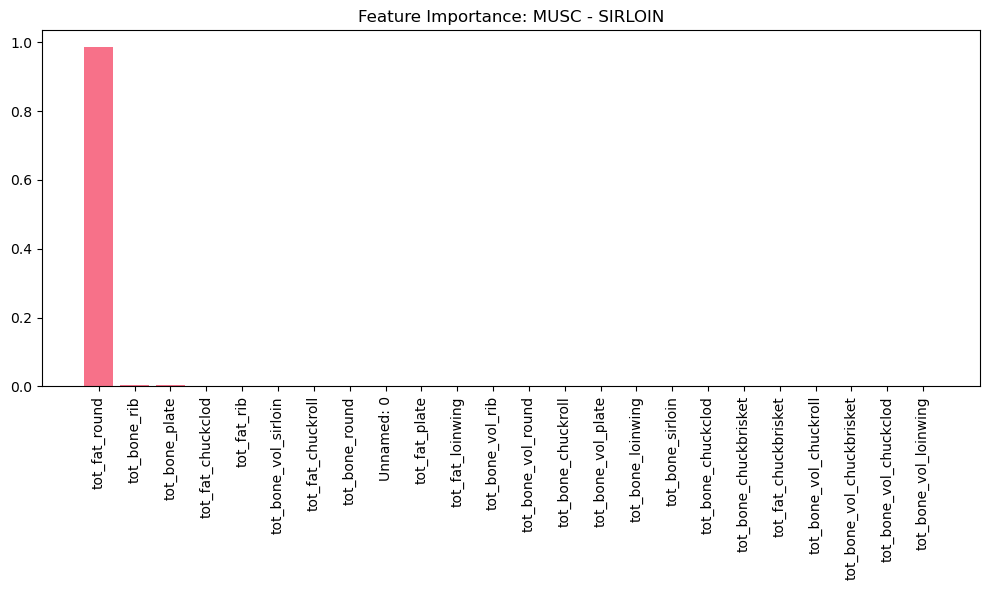

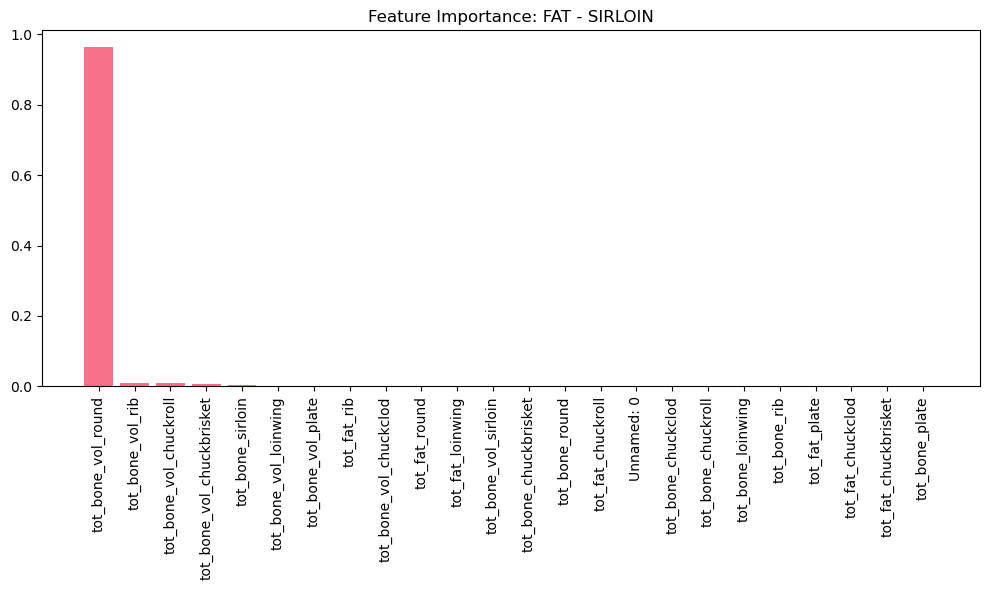

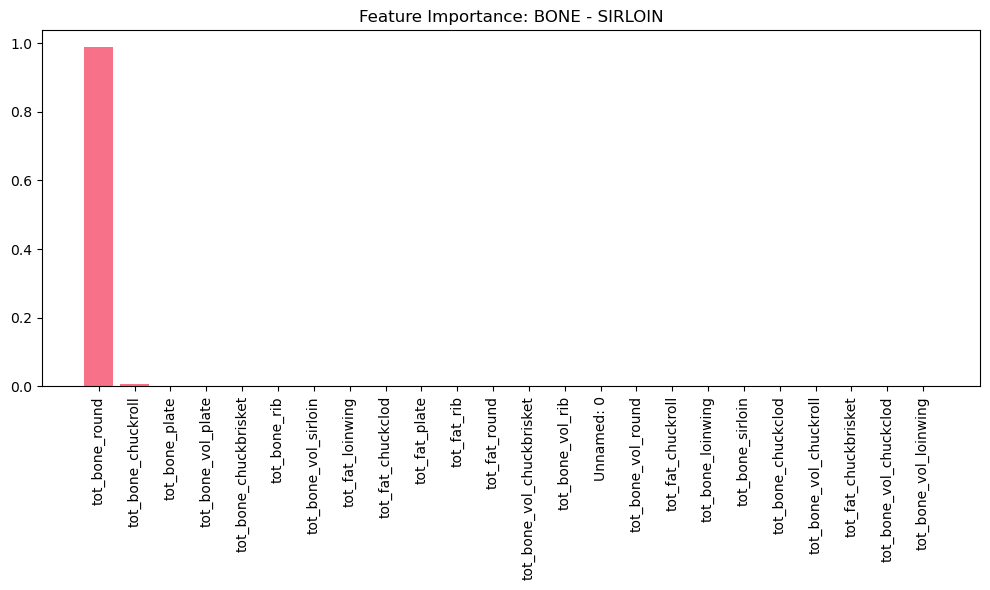


Detailed Results by Tissue and Cut:
----------------------------------

MUSC:

FAT:

BONE:


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from pathlib import Path
import os

# Set style for plots
# plt.style.use('seaborn')
sns.set_palette('husl')

# Create necessary directories if they don't exist
os.makedirs('outputs', exist_ok=True)

# Load test data
try:
    data = pd.read_csv('data/ct_composition.csv')
    print("Data loaded successfully")
except FileNotFoundError:
    print("Error: ct_composition.csv not found in data directory")
    data = None

# Load models and scalers with error handling
models = {}
scalers = {}

def load_model(path):
    """Load a model or scaler with error handling"""
    try:
        return joblib.load(path)
    except Exception as e:
        print(f"Error loading {path}: {str(e)}")
        return None

# Load scalers first
print("\nLoading scalers...")
X_scaler = load_model('outputs/X_scaler.joblib')
y_scaler = load_model('outputs/y_scaler.joblib')

if X_scaler is None or y_scaler is None:
    print("Warning: One or both scalers failed to load")

# Load tissue models
print("\nLoading tissue models...")
for tissue in ['MUSC', 'FAT', 'BONE']:
    models[tissue] = {}
    for cut in ['SIRLOIN', 'ROUND', 'LOINWING', 'RIB', 'CHUCKROLL', 'CHUCKCLOD', 'CHUCKBRISKET']:
        model_path = f'models/tissue_models/{tissue}_{cut}_model.joblib'
        if Path(model_path).exists():
            model = load_model(model_path)
            if model is not None:
                models[tissue][cut] = model
                print(f"Loaded model for {tissue} - {cut}")

def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics with error handling"""
    try:
        return {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'R2': r2_score(y_true, y_pred),
            'Error %': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        }
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        return None

# Calculate performance metrics for each tissue type and cut
results = {}
if data is not None and X_scaler is not None and y_scaler is not None:
    for tissue in models:
        results[tissue] = {}
        for cut in models[tissue]:
            try:
                # Prepare features
                X = data.drop(columns=['id'] if 'id' in data.columns else [])
                y_true = data[f'tot_{tissue.lower()}_vol_{cut.lower()}']
                
                # Scale features
                X_scaled = X_scaler.transform(X)
                
                # Make predictions
                y_pred = models[tissue][cut].predict(X_scaled)
                y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
                
                # Calculate metrics
                results[tissue][cut] = calculate_metrics(y_true, y_pred)
                if results[tissue][cut] is not None:
                    print(f"Calculated metrics for {tissue} - {cut}")
            except Exception as e:
                print(f"Error processing {tissue} - {cut}: {str(e)}")
else:
    print("Cannot calculate metrics: Missing data or scalers")

def plot_error_distribution(results):
    """Plot error distribution across tissues and cuts"""
    if not results:
        print("No results to plot")
        return
    
    error_data = []
    for tissue in results:
        for cut in results[tissue]:
            if results[tissue][cut] is not None:
                error_data.append({
                    'Tissue': tissue,
                    'Cut': cut,
                    'Error %': results[tissue][cut]['Error %']
                })
    
    if error_data:
        df = pd.DataFrame(error_data)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x='Cut', y='Error %', hue='Tissue')
        plt.title('Prediction Error by Tissue Type and Cut')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('outputs/error_distribution.png')
        plt.show()

def plot_feature_importance(model, feature_names, title):
    """Plot feature importance for a given model"""
    if model is None:
        print(f"Cannot plot feature importance for {title}: Model not loaded")
        return
    
    try:
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importance: {title}')
        plt.bar(range(len(importance)), importance[indices])
        plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig(f'outputs/feature_importance_{title.lower().replace(" ", "_")}.png')
        plt.show()
    except Exception as e:
        print(f"Error plotting feature importance for {title}: {str(e)}")

def print_summary_statistics(results):
    """Print summary statistics for each tissue type"""
    if not results:
        print("No results to summarize")
        return None
    
    summary = {}
    for tissue in results:
        valid_errors = [results[tissue][cut]['Error %'] 
                       for cut in results[tissue] 
                       if results[tissue][cut] is not None]
        
        if valid_errors:
            summary[tissue] = {
                'Mean Error %': np.mean(valid_errors),
                'Std Error %': np.std(valid_errors),
                'Best Cut': min([(cut, results[tissue][cut]['Error %']) 
                                for cut in results[tissue] 
                                if results[tissue][cut] is not None],
                               key=lambda x: x[1])[0],
                'Worst Cut': max([(cut, results[tissue][cut]['Error %']) 
                                 for cut in results[tissue] 
                                 if results[tissue][cut] is not None],
                                key=lambda x: x[1])[0]
            }
    
    return pd.DataFrame(summary).T if summary else None

# Generate plots and print results
plot_error_distribution(results)

# Plot feature importance for each tissue type (using SIRLOIN as example)
if data is not None:
    feature_names = data.drop(columns=['id'] if 'id' in data.columns else []).columns
    for tissue in models:
        if 'SIRLOIN' in models[tissue]:
            plot_feature_importance(models[tissue]['SIRLOIN'], feature_names, f'{tissue} - SIRLOIN')

# Print summary statistics
summary_df = print_summary_statistics(results)
if summary_df is not None:
    print("\nModel Performance Summary:")
    print("-------------------------")
    print(summary_df)
    
    # Save summary to file
    summary_df.to_csv('outputs/model_performance_summary.csv')

# Print detailed results
print("\nDetailed Results by Tissue and Cut:")
print("----------------------------------")
for tissue in results:
    print(f"\n{tissue}:")
    for cut in results[tissue]:
        if results[tissue][cut] is not None:
            metrics = results[tissue][cut]
            print(f"\n{cut}:")
            print(f"  MAE: {metrics['MAE']:.2f}")
            print(f"  RMSE: {metrics['RMSE']:.2f}")
            print(f"  R2: {metrics['R2']:.3f}")
            print(f"  Error %: {metrics['Error %']:.2f}%")